In [1]:
import os
import ast
import matplotlib.pyplot as plt
import sys
sys.path.append(os.path.join(os.getcwd(), '../desi/'))
import numpy as np
import emcee
import corner
from IPython.display import display, Latex, Math
from copy import deepcopy

if './SelfCalGroupFinder/py/' not in sys.path:
    sys.path.append('./SelfCalGroupFinder/py/')
from pyutils import *
from groupcatalog import *
import plotting as pp
import catalog_definitions as cat

%load_ext autoreload
%autoreload 2

# 10 Parameters associated with galaxy colors
# Multiple configurations could produce the same LHMR, fsat, etc.
# The actual values of these parameters is not of central interest;
# it's the implied LHMR, fsat, etc. that we really care about.
# Thus any degeneracies in these parameters are not a concern.

# A zeroth and first order polynomial in log L_gal for B_sat, which controls the satelite threshold
# Bsat,r = β_0,r + β_L,r(log L_gal − 9.5)
# Bsat,b = β_0,b + β_L,b(log L_gal − 9.5)
# Constrained from projected two-point clustering comparison for r,b seperately

# Weights for each galaxy luminosity, when abundance matching
# log w_cen,r = (ω_0,r / 2) (1 + erf[(log L_gal - ω_L,r) / σ_ω,r)] ) 
# log w_cen,b = (ω_0,b / 2) (1 + erf[(log L_gal - ω_L,b) / σ_ω,b)] ) 
# Constrained from Lsat,r/Lsat,b ratio and projected two-point clustering.

# A secondary, individual galaxy property can be introduced to affect the weight for abundance matching.
#  2 Parameters (one for each red and blue)
# w_χ,r = exp(χ/ω_χ,r)
# w_χ,b = exp(χ/ω_χ,b)
# Constrained from Lsat(χ|L_gal) data.

# Ideal Chi^2 Estimate = N_dof = N_data - N_params = 100 - 10 = 90


#Job ID                    Name             User            Time Use S Queue
#------------------------- ---------------- --------------- -------- - -----
#15016.master.local         ian.optuna0      imw2293         415:05:3 R default        (TPE)
#15017.master.local         ian.optuna1      imw2293         70:22:47 R default        (Q MC)
#15018.master.local         ian.optuna2      imw2293         404:17:4 R default        (GP)
#15019.master.local         ian.emcee3       imw2293         72:43:09 R default        (emcee Stretch)


# Analyze Results

In [ ]:
# 94 became 112, then 112, 117, 116, 111
# Then again without preprocess:
# 115.9, 109.4, 115.9, 115.9, 115.9, 115.9

In [ ]:
gc = deepcopy(cat.bgs_sv3_10p_mcmc)
best = gc.load_best_params_across_runs()
print(best)

In [ ]:
gc.preprocess()
gc.run_group_finder(popmock=True, silent=True)
gc.calc_wp_for_mock()
gc.chisqr()
gc.postprocess()
gc.dump()

In [ ]:
pp.proj_clustering_plot(gc)
#p.proj_clustering_plot(deserialize(cat.sdss_colors))
pp.proj_clustering_plot(deserialize(cat.sdss_colors_v2))
#p.proj_clustering_plot(deserialize(cat.sdss_colors_chi))
#p.proj_clustering_plot(deserialize(cat.sdss_colors_chi_v2))

In [ ]:
pp.lsat_data_compare_plot(gc)
pp.lsat_data_compare_plot(deserialize(cat.sdss_colors_v2))

In [ ]:
pp.plots(gc)

In [ ]:
# Folder number to look in
run = 4
reader = gc.get_backend_for_run(run)

if isinstance(reader, emcee.backends.backend.Backend):

    samples = reader.get_chain()
    ndim = reader.shape[1]
    print(f'Number of steps: {samples.shape[0] * samples.shape[1]} (total); {samples.shape[0]} (per walker), ')
    print(f'Number of walkers: {samples.shape[1]}')
    print(f'Number of parameters: {ndim}')

    try:
        tau = reader.get_autocorr_time()
        print(tau)
    except:
        print("Not burnt in yet")

    burn_number = 0 # TODO choose this by inspecting the chains above. wait for convergence in all parameters
    thin_number = 1
    flat_samples = reader.get_chain(discard=burn_number, thin=thin_number, flat=True)
    flat_samples.shape

In [ ]:
#sdss_colors_mine = SDSSGroupCatalog.from_MCMC(reader, "Best From Chains", SDSS_v2_DAT_FILE, SDSS_v2_GALPROPS_FILE)
#sdss_colors_mine.run_group_finder(popmock=True)
#sdss_colors_mine.calc_wp_for_mock()
#sdss_colors_mine.postprocess()


In [ ]:
#bad = [15,23,29] # this walker went off the deep end...
bad = []
# remove the 15th walker 
#flat_samples = np.delete(samples, 15, 1)
# and first burn_number steps from each walker and flatten
#flat_samples = flat_samples[burn_number:, :].reshape((-1, ndim))
#flat_samples.shape

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 2.5*ndim), sharex=True)
labels = ['$\\omega_{L,b}$', '$\\sigma_{\\omega,b}$', '$\\omega_{L,r}$', '$\\sigma_{\\omega,r}$', '$\\omega_{0,b}$', '$\\omega_{0,r}$', '$\\beta_{0,r}$', '$\\beta_{L,r}$', '$\\beta_{0,b}$', '$\\beta_{L,b}$']
good_walkers = list(np.arange(samples.shape[1]))
for b in bad:
    good_walkers.remove(b)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, good_walkers, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    # label each walker number
    #for j in good_walkers:
    #    ax.text(10000, samples[10000, j, i], f'{j}', color='k', fontsize=6)

axes[-1].set_xlabel("step number")

In [ ]:
# The corner plot shows all 1D and 2D projections of the posterior probabilities of your parameters.
# This is useful because it quickly demonstrates all of the covariances between parameters. 
# Also, the way that you find the marginalized distribution for a parameter or set of parameters 
#   using the results of the MCMC chain is to project the samples into that plane and then make 
#   an N-dimensional histogram. 
# That means that the corner plot shows the marginalized distribution for each parameter independently 
#   in the histograms along the diagonal and then the marginalized two dimensional distributions 
#   in the other panels.
ranges = [(10,20),(0,5),(-2,30),(-5,20),(0,35),(-10,15),(-6,6),(4,25),(8,25),(-25,5)]
fig = corner.corner(flat_samples, labels=labels, range=ranges)

In [ ]:
# Show best model (lowest chi squared)
idx = np.argmax(reader.get_log_prob(flat=True))
all_flat_samples = reader.get_chain(flat=True)
best_fit = all_flat_samples[idx]
# Print with labels, need latex formatting
print(f"BEST MODEL (chi={reader.get_log_prob(flat=True)[idx]:.3f})")
for i in range(len(labels)):
    display(Latex(f'{labels[i]} = {best_fit[i]:.3f}'))

# Then print means of the posteriors
print("MEAN MODEL")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = f"{labels[i]} = ${mcmc[1]:.3f}_{{-{q[0]:.3f}}}^{{{q[1]:.3f}}}$"
    display(Latex(txt))

# Extract Variances from Log Files

fsat_len: 8, lhmr_len: 8
[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  3.941341e+07 7.727414e+07 1.349180e+08 2.094195e+08 3.290254e+08
  4.885109e+08 7.842470e+08 1.246469e+09 1.889173e+09 2.580036e+09
  3.399556e+09 4.259564e+09 5.270317e+09 6.474891e+09 8.168211e+09
  1.013241e+10 1.187642e+10 1.381269e+10 1.576871e+10 1.795882e+10
  2.018338e+10 2.269514e+10 2.509462e+10 2.785856e+10 3.058363e+10
  3.434674e+10 3.789796e+10 4.239752e+10 4.692561e+10 4.909829e+10
  5.492452e+10 5.944766e+10 6.476050e+10 6.970533e+10 7.483393e+10
  7.600464e+10 7.763703e+10 8.778417e+10 9.751433e+10 9.922132e+10
  1.059711e+11 1.209402e+11 1.233766e+11 1.545360e+11 1.495477e+11
  1.680338e+11 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000

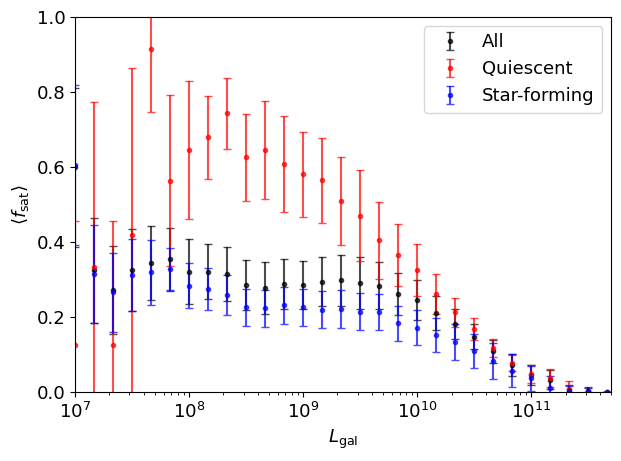

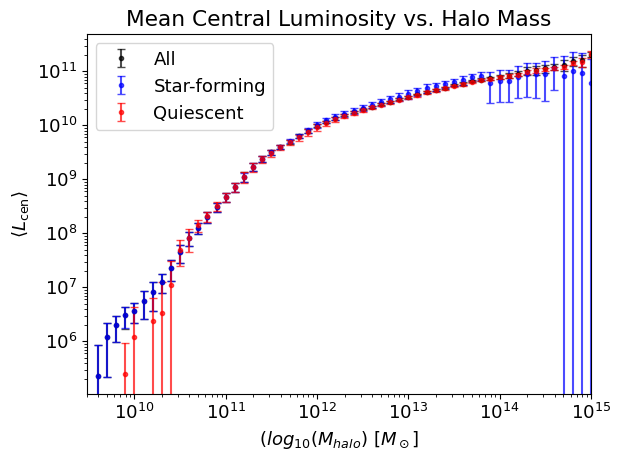

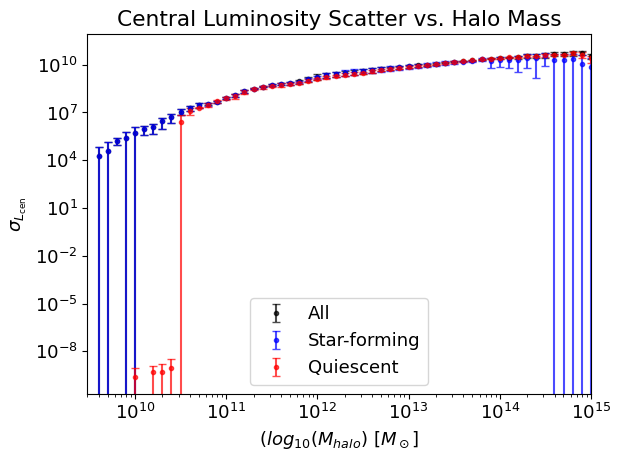

In [ ]:
# This will save off a .npy file with the array of fsat values
save_from_log(PY_SRC_FOLDER + 'test_3', overwrite=True)

fsat_std, fsatr_std, fsatb_std, fsat_mean, fsatr_mean, fsatb_mean = fsat_variance_from_saved()
#np.save(OUTPUT_FOLDER + 'std_fsat.npy', (fsat_std, fsatr_std, fsatb_std, fsat_mean, fsatr_mean, fsatb_mean))

lhmr_r_mean, lhmr_r_std, lhmr_r_scatter_mean, lhmr_r_scatter_std, lhmr_b_mean, lhmr_b_std, lhmr_b_scatter_mean, lhmr_b_scatter_std, lhmr_all_mean, lhmr_all_std, lhmr_all_scatter_mean, lhmr_all_scatter_std = lhmr_variance_from_saved()

plt.figure()
plt.errorbar(L_gal_bins, fsat_mean, yerr=fsat_std, fmt='.', color='k', label='All', capsize=3, alpha=0.7)
plt.errorbar(L_gal_bins, fsatr_mean, yerr=fsatr_std, fmt='.', color='r', label='Quiescent', capsize=3, alpha=0.7)
plt.errorbar(L_gal_bins, fsatb_mean, yerr=fsatb_std, fmt='.', color='b', label='Star-forming', capsize=3, alpha=0.7)
plt.xlabel('$L_{\mathrm{gal}}$')
plt.ylabel(r'$\langle f_{\mathrm{sat}} \rangle$')
plt.legend()
plt.xscale('log')
plt.xlim(1E7, 5E11)
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()

plt.figure()
plt.errorbar(Mhalo_bins, lhmr_all_mean, yerr=lhmr_all_std, fmt='.', color='k', label='All', capsize=3, alpha=0.7)
plt.errorbar(Mhalo_bins, lhmr_b_mean, yerr=lhmr_b_std, fmt='.', color='b', label='Star-forming', capsize=3, alpha=0.7)
plt.errorbar(Mhalo_bins, lhmr_r_mean, yerr=lhmr_r_std, fmt='.', color='r', label='Quiescent', capsize=3, alpha=0.7)
plt.xlabel('($log_{10}(M_{halo})~[M_\\odot]$')
plt.ylabel(r'$\langle L_{\mathrm{cen}} \rangle$')
plt.title("Mean Central Luminosity vs. Halo Mass")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(3E9, 1E15)
plt.tight_layout()
plt.show()

plt.figure()
plt.errorbar(Mhalo_bins, lhmr_all_scatter_mean, yerr=lhmr_all_scatter_std, fmt='.', color='k', label='All', capsize=3, alpha=0.7)
plt.errorbar(Mhalo_bins, lhmr_b_scatter_mean, yerr=lhmr_b_scatter_std, fmt='.', color='b', label='Star-forming', capsize=3, alpha=0.7)
plt.errorbar(Mhalo_bins, lhmr_r_scatter_mean, yerr=lhmr_r_scatter_std, fmt='.', color='r', label='Quiescent', capsize=3, alpha=0.7)
plt.xlabel('($log_{10}(M_{halo})~[M_\\odot]$')
plt.ylabel(r'$\sigma_{L_{\mathrm{cen}}}$')
plt.title("Central Luminosity Scatter vs. Halo Mass")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(3E9, 1E15)
plt.tight_layout()
plt.show()

# Analyze MCMC using manual output file
But this is problematic in that it resets the model count to 1 everytime we startup after a crash

In [ ]:
# My Chains and Distributions of Parameters from the out.i file
# Can get parameter info from the output file as well

folder_num = 1

models = []
chi = []
contributions = []
with open(f'../../MCMC/mcmc_{folder_num}/out.{folder_num}', 'r') as file:
    model_num = -1
    for line in file:
        if line.startswith('MODEL'):
            model_num = int(line.split(' ', 2)[-1].strip())
        elif line.startswith('{\'zmin\':'):
            parameter_dict = ast.literal_eval(line)
            models.append(parameter_dict)
        elif line.startswith('CHI'):
            chi.append(float(line.split(' ', 2)[-1].strip()))
        elif line.startswith('CONTRIBUTIONS'):
            contributions.append(ast.literal_eval(line.split(' ', 1)[1].strip()))

    assert len(models) == len(chi)

def get_parameter_values(parameter_name):
    return [model[parameter_name] for model in models]

exclusions = ['zmin', 'zmax', 'frac_area', 'fluxlim', 'color']

contributions = np.array(contributions)

In [ ]:
print("For low chi squared models, the mean contributions come from:")
for i in range(contributions.shape[1]):
    filtered_contributions = np.where(np.array(chi) < 150, contributions[:,i], np.zeros(contributions.shape[0]))
    print(f"Mean={np.mean(filtered_contributions):.2f}, var={np.var(filtered_contributions):.2f}")

print("For high chi squared models, the mean contributions come from:")
for i in range(contributions.shape[1]):
    filtered_contributions = np.where(np.array(chi) > 150, contributions[:,i], np.zeros(contributions.shape[0]))
    print(f"Mean={np.mean(filtered_contributions):.2f}, var={np.var(filtered_contributions):.2f}")

#indexes_sorted = np.argsort(chi)
#junk=plt.hist(np.log10(chi), bins=50)
#chi_sorted = np.sort(chi)
#chi_sorted[len(chi_sorted)//2]

In [ ]:
# My versions of chain plots and parameter distributions
for pname in models[0]:
    if pname in exclusions:
        continue
    values=get_parameter_values(pname)
    plt.plot(values, color="k")
    plt.xlabel('Iteration')
    plt.ylabel(f'Parameter Value')
    plt.title(f'Parameter Chain for {pname}')
    plt.show()

    plt.hist(values, 100, color="k", histtype="step")
    plt.xlabel(f"{pname}")
    plt.ylabel(f"$p({pname})$")
    plt.gca().set_yticks([])
    plt.show()

plt.plot(chi)
plt.xlabel('Iteration')
plt.ylabel('Chi Squared')
plt.title('Chi Squared Chain')
plt.show()

In [ ]:
# Show best model
best_model = models[chi.index(min(chi))]
print(f'Best model is model {chi.index(min(chi))} with chi squared of {min(chi)}')

#compare each property of best model to cat.sdss_colors.GF_props
for key in best_model:
    if key in exclusions:
        continue
    print(f'{key.ljust(12)}:  {best_model[key]:.4} vs {cat.sdss_colors.GF_props[key]:.4} ({100 * (best_model[key] - cat.sdss_colors.GF_props[key]) / cat.sdss_colors.GF_props[key]:.2f}%)')


In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))